# Financial data analysis with arhmm

In [53]:
%%capture
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax

In [54]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import seaborn as sns

from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation

import numpy as np
import pandas as pd
import warnings

In [55]:
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink"
]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

### loading the dataset

In [56]:
data = pd.read_csv("Financial-Data/stocks/TSLA.csv")
data = data.dropna()
data.head()

close_diff = np.diff(np.log(data['Close']))[1:]
open_diff = np.diff(np.log(data['Open']))[1:]

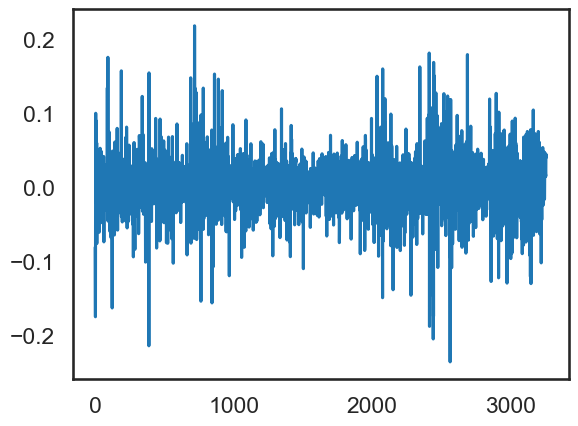

In [57]:
plt.plot(close_diff)

## fitting a model

In [58]:
# Now fit an HMM to the emissions
key1, key2 = jr.split(jr.PRNGKey(0), 2)
num_states = 4
emission_dim = 2
num_lags = 1


emissions = np.vstack((open_diff, close_diff))

emissions = jnp.array(emissions.T)

time_bins = len(emissions)

# Initialize with K-Means
arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)
params, props = arhmm.initialize(key=jr.PRNGKey(1), method="kmeans", emissions=emissions)

inputs = arhmm.compute_inputs(emissions)

# Fit with EM
fitted_params, lps = arhmm.fit_em(params, props, emissions, inputs=inputs)

/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Plot the log-likelihood

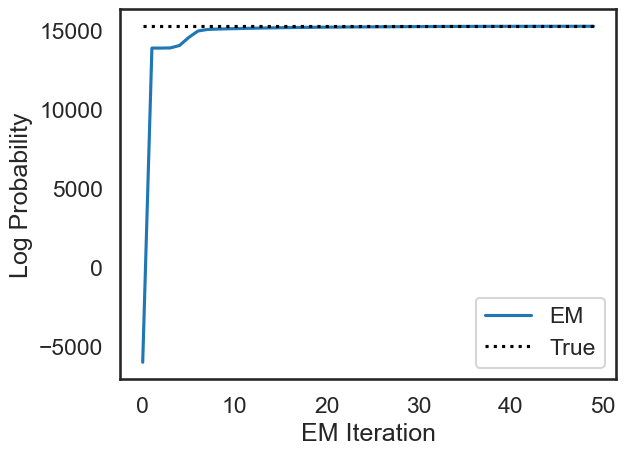

In [59]:
true_lp = arhmm.marginal_log_prob(fitted_params, emissions, inputs=inputs)
plt.plot(lps, label="EM")
plt.plot(true_lp * jnp.ones(len(lps)), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

## inspecting the parameters

In [60]:
# inspecitng the fitted parameters
for i in range(len(fitted_params)):
    print(fitted_params[i])

ParamsStandardHMMInitialState(probs=Array([0.09125336, 0.07142857, 0.07159884, 0.76571894], dtype=float32))
ParamsStandardHMMTransitions(transition_matrix=Array([[1.6263810e-01, 4.1115347e-02, 3.4086391e-01, 4.5538267e-01],
       [7.4415450e-04, 8.5911918e-01, 1.1317017e-01, 2.6966456e-02],
       [2.0050530e-03, 9.0804778e-02, 8.5989988e-01, 4.7290266e-02],
       [9.5911527e-01, 9.9554297e-04, 2.6911391e-02, 1.2977822e-02]],      dtype=float32))
ParamsLinearRegressionHMMEmissions(weights=Array([[[-0.39837232,  0.5367652 ],
        [-0.05475432,  0.06152698]],

       [[-0.05504737,  0.8569079 ],
        [-0.00633866, -0.00237344]],

       [[-0.23372713,  0.85413414],
        [-0.04296631,  0.04027547]],

       [[-0.06183656,  0.98157674],
        [ 0.1639021 , -0.19370571]]], dtype=float32), biases=Array([[ 0.00349071,  0.00709559],
       [ 0.00038175,  0.00264742],
       [ 0.00054044,  0.0006531 ],
       [-0.00611705, -0.00392796]], dtype=float32), covs=Array([[[1.6032807e-03,

# find most likely states

In [61]:
posterior = arhmm.smoother(fitted_params, emissions, inputs=inputs)
most_likely_states = arhmm.most_likely_states(fitted_params, emissions, inputs=inputs)

## plot of most likely states

Text(0, 0.5, 'Close Values')

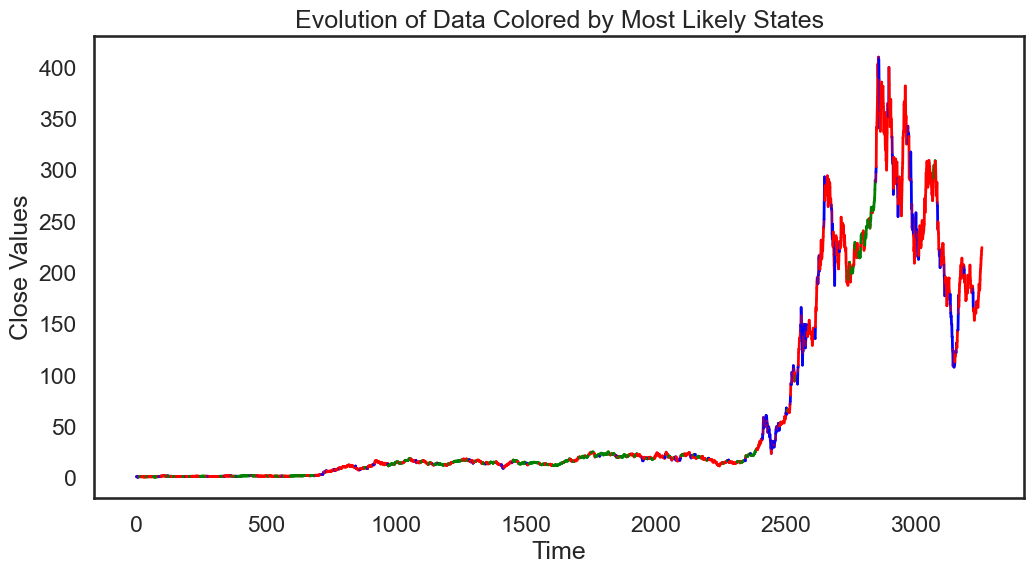

In [62]:
d = data['Close'][1:].to_numpy()

colors = ['blue', 'green', 'red', 'purple']
state_colors = [colors[state] for state in most_likely_states]

fig, ax = plt.subplots(figsize=(12, 6))

for i in range(1, len(d)-2):
    ax.plot([i-1, i], [d[i-1], d[i]], color=state_colors[i], linewidth=2)

ax.set_title('Evolution of Data Colored by Most Likely States')
ax.set_xlabel('Time')
ax.set_ylabel('Close Values')

## plot of distribution of hidden states

Text(0.5, 0, 'time')

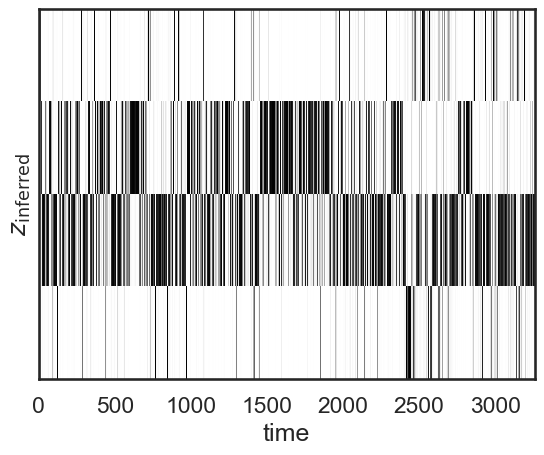

In [63]:
plot_slice = (0, time_bins)
plt.imshow(posterior.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

# sample new data and plot them

(3258, 2)


Text(0, 0.5, 'Emissions')

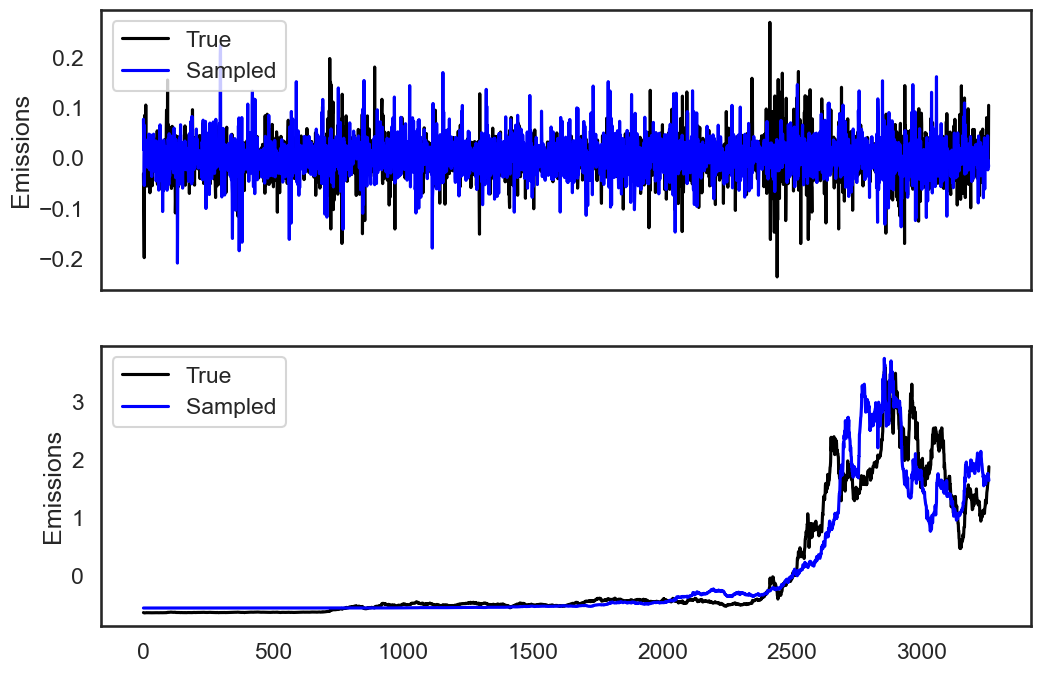

In [64]:
# can add here also the first obs of the real data
# prev_emissions = data['Close'].iloc[1]
sampled_states, sampled_emissions = arhmm.sample(fitted_params, jr.PRNGKey(0), time_bins, np.array(emissions[0:num_lags]).reshape(num_lags, emission_dim))

sampled_emissions_open = sampled_emissions[:,0]
sampled_emissions_close = sampled_emissions[:,1]

print(sampled_emissions.shape)

initial_value = data['Close'].iloc[1]
recovered_log = np.cumsum(np.concatenate(([np.log(initial_value)], sampled_emissions_close.reshape(-1))))
recovered_series = np.exp(recovered_log)

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(emissions[:,0], color="black", label="True")
ax[0].plot(sampled_emissions_close, color="blue", label="Sampled")
ax[0].legend(loc="upper left")
ax[0].set_ylabel("Emissions")


d = data['Close'][1:].to_numpy()
d = (d-np.mean(d))/np.std(d)

recovered_series = (recovered_series - np.mean(recovered_series)) / np.std(recovered_series)

ax[1].plot(d, color="black", label="True")
ax[1].plot(recovered_series, color="blue", label="Sampled")
ax[1].legend(loc="upper left")
ax[1].set_ylabel("Emissions")

Text(0.5, 0, 'time')

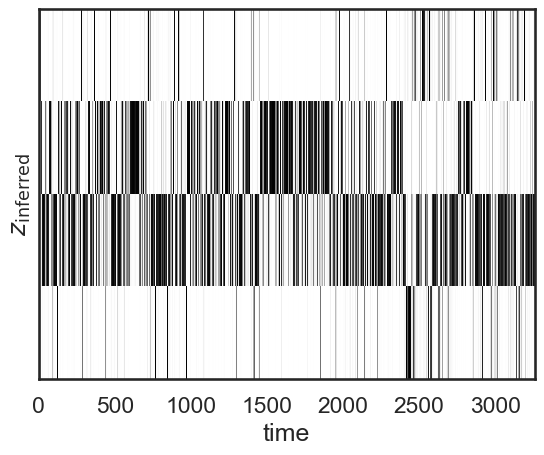

In [65]:
plot_slice = (0, time_bins)
plt.imshow(posterior.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")